In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#!cp /content/drive/My\ Drive/Bengali/valid_gray.zip /content/
#!cp /content/drive/My\ Drive/Bengali/train_gray.zip /content/

import os

!cp /content/drive/My\ Drive/Bengali/train_gen.csv /content/
!cp /content/drive/My\ Drive/Bengali/valid_gen.csv /content/

!mkdir /content/train/
!cp /content/drive/My\ Drive/Bengali/train.zip /content/train/
os.chdir('/content/train/')
!unzip train.zip
os.chdir('/content/')



!rm /content/train/train.zip

In [4]:
!pip uninstall tensorflow
!pip install tensorflow-gpu

Uninstalling tensorflow-1.15.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/freeze_graph
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-1.15.0.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
    /usr/local/lib/python3.6/dist-packages/tensorflow_core/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-1.15.0
     |████████████████████████████████| 421.8MB 38kB/s 
     |████████████████████████████████| 3.8MB 31.2MB/s 
     |████████████████████████████████| 450kB 56.8MB/s 
     |████████████████████████████████| 81kB 13.3MB/s 
ERROR: tensorboard 2.1.0 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.11.0 w

In [1]:
import cv2
from tqdm import tqdm_notebook as tqdm
import os
import zipfile
import io
import tensorflow as tf
import pandas as pd
import numpy as np
import tensorflow.keras as keras
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
tf.__version__

'2.1.0'

# Classifying Graheme Roots

In [0]:
train_gen_df = pd.read_csv('train_gen.csv', dtype=str)
valid_gen_df = pd.read_csv('valid_gen.csv', dtype=str)

test_gen_df = train_gen_df[-2000:]
train_gen_df = train_gen_df[:-2000]

### 168 unique target classes to train on

In [0]:
n_train = len(train_gen_df)
n_valid = len(valid_gen_df)

combined_df = pd.concat([train_gen_df, valid_gen_df, test_gen_df])
combined_df = pd.get_dummies(combined_df, columns=['class'])
train_gen_df = combined_df.iloc[:n_train]
valid_gen_df = combined_df.iloc[n_train:n_train+n_valid]
test_gen_df = combined_df.iloc[n_train+n_valid:]

In [0]:
from tensorflow.keras.layers import Dense,BatchNormalization,MaxPool1D,Input,Dropout,Conv1D,Conv2D,Flatten,MaxPool2D,LeakyReLU # keras layers
from tensorflow.keras.models import Model #Model class
from tensorflow.keras.optimizers import Adam #optimizer
from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint,EarlyStopping

In [0]:
model = keras.Sequential()
model.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu'))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(LeakyReLU(alpha=0.17))
model.add(BatchNormalization(momentum=0.15))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu'))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(LeakyReLU(alpha=0.17))
model.add(BatchNormalization(momentum=0.15))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(LeakyReLU())
model.add(Dropout(rate=0.35))
model.add(BatchNormalization(momentum=0.15))
model.add(Dropout(rate=0.3))
model.add(Dense(192, activation = "relu"))
model.add(Dense(168, activation = 'softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
labels = train_gen_df.columns.tolist()[1:]

In [30]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_gen_df,
        directory='/content/train/',
        x_col="images",
        y_col=labels,
        target_size=(128, 128),
        class_mode='other',
        batch_size=32)

validation_generator = test_datagen.flow_from_dataframe(
        dataframe=valid_gen_df,
        directory='/content/train/',
        x_col="images",
        y_col=labels,
        target_size=(128, 128),
        class_mode='other',
        batch_size=32)

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_gen_df,
        directory='/content/train/',
        x_col="images",
        y_col=labels,
        target_size=(128, 128),
        class_mode='other',
        batch_size=32)

Found 197840 validated image filenames.
Found 1000 validated image filenames.
Found 2000 validated image filenames.


In [0]:
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", 
                               monitor = 'val_acc',
                               verbose=1, 
                               save_best_only=True)

In [42]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size

history = model.fit(train_generator,
                              validation_data=validation_generator,
                              validation_steps=STEP_SIZE_VALID,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              callbacks=[checkpointer],
                              epochs=10)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 6182 steps, validate for 31 steps
Epoch 1/10
6182/6182 [==============================] - 818s 132ms/step - loss: 1.0094 - accuracy: 0.7121 - val_loss: 0.8489 - val_accuracy: 0.7631
Epoch 2/10
6182/6182 [==============================] - 868s 140ms/step - loss: 0.9588 - accuracy: 0.7239 - val_loss: 0.7864 - val_accuracy: 0.7762
Epoch 3/10
6182/6182 [==============================] - 885s 143ms/step - loss: 0.9220 - accuracy: 0.7335 - val_loss: 0.8174 - val_accuracy: 0.7752
Epoch 4/10
6182/6182 [==============================] - 842s 136ms/step - loss: 0.8921 - accuracy: 0.7428 - val_loss: 0.7982 - val_accuracy: 0.7792
Epoch 5/10
6182/6182 [==============================] - 841s 136ms/step - loss: 0.8651 - accuracy: 0.7492 - val_loss: 0.7649 - val_accuracy: 0.7933
Epoch 6/10
6182/6182 [==============================] - 847s 137ms/step - loss: 0.8414 - accuracy: 0.7556 - val_loss: 0.7659 - val_accuracy: 0.7792
Epoch 7/10
6182/61

In [0]:
import h5py
os.chdir('/content/')
model.save("model_trial5.h5")

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

hist_df = pd.DataFrame({'accuracy':acc, 'val_accuracy':val_acc, 'loss':loss, 'val_loss':val_loss})
hist_df.to_csv('hist_trial5.csv', index=False)

In [0]:
!cp /content/model_trial5.h5 /content/drive/My\ Drive/Bengali/
!cp /content/hist_trial5.csv /content/drive/My\ Drive/Bengali/

[]

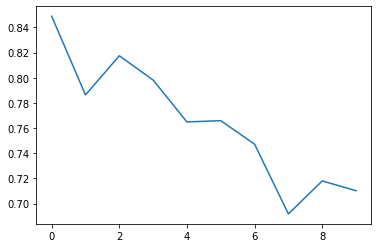

In [46]:
plt.plot(history.history['val_loss'])
plt.plot()

In [47]:
model.evaluate(test_generator)

  ...
    to  
  ['...']
63/63 [==============================] - 1s 20ms/step - loss: 0.6859 - accuracy: 0.8085


[0.6859013206428952, 0.8085]

Using TensorFlow backend.


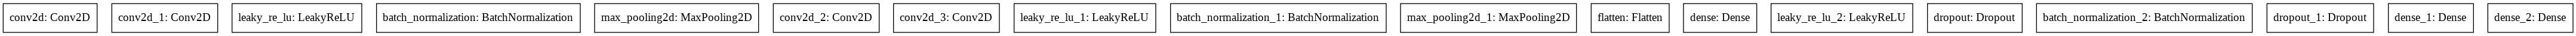

In [40]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

# Vowel diacritic classifier

In [68]:
from tensorflow.keras.models import load_model 
vowel_model = load_model('model_trial5.h5')

In [0]:
df = pd.read_csv('train_vowels.csv')

In [0]:
n_valid = 2000
n_test = 1000
n_train = len(df) - n_valid - n_test

train_gen_df = df.iloc[:n_train]
valid_gen_df = df.iloc[n_train:-n_test]
test_gen_df = df.iloc[-n_test:]

In [0]:
model.add(Dense(11, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [97]:
labels = train_gen_df.columns.tolist()[1:]

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_gen_df,
        directory='/content/train/',
        x_col="image",
        y_col=labels,
        target_size=(128, 128),
        class_mode='other',
        batch_size=32)

validation_generator = test_datagen.flow_from_dataframe(
        dataframe=valid_gen_df,
        directory='/content/train/',
        x_col="image",
        y_col=labels,
        target_size=(128, 128),
        class_mode='other',
        batch_size=32)

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_gen_df,
        directory='/content/train/',
        x_col="image",
        y_col=labels,
        target_size=(128, 128),
        class_mode='other',
        batch_size=32)

Found 197840 validated image filenames.
Found 2000 validated image filenames.
Found 1000 validated image filenames.


In [0]:
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", 
                               monitor = 'val_acc',
                               verbose=1, 
                               save_best_only=True)

In [99]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size

history = model.fit(train_generator,
                              validation_data=validation_generator,
                              validation_steps=STEP_SIZE_VALID,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              callbacks=[checkpointer],
                              epochs=10)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 6182 steps, validate for 62 steps
Epoch 1/10
6182/6182 [==============================] - 834s 135ms/step - loss: 1.3644 - accuracy: 0.5271 - val_loss: 0.9845 - val_accuracy: 0.6966
Epoch 2/10
6182/6182 [==============================] - 836s 135ms/step - loss: 0.7725 - accuracy: 0.7616 - val_loss: 0.5150 - val_accuracy: 0.8438
Epoch 3/10
6182/6182 [==============================] - 842s 136ms/step - loss: 0.5249 - accuracy: 0.8361 - val_loss: 0.3998 - val_accuracy: 0.8765
Epoch 4/10
6182/6182 [==============================] - 840s 136ms/step - loss: 0.4274 - accuracy: 0.8644 - val_loss: 0.3604 - val_accuracy: 0.8866
Epoch 5/10
6182/6182 [==============================] - 841s 136ms/step - loss: 0.3743 - accuracy: 0.8801 - val_loss: 0.2785 - val_accuracy: 0.9123
Epoch 6/10
6182/6182 [==============================] - 823s 133ms/step - loss: 0.3414 - accuracy: 0.8906 - val_loss: 0.2655 - val_accuracy: 0.9062
Epoch 7/10
6182/61

In [0]:
import h5py
os.chdir('/content/')
model.save("vowel_model_trial1.h5")

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

hist_df = pd.DataFrame({'accuracy':acc, 'val_accuracy':val_acc, 'loss':loss, 'val_loss':val_loss})
hist_df.to_csv('vowel_hist_trial1.csv', index=False)

In [0]:
!cp /content/vowel_model_trial1.h5 /content/drive/My\ Drive/Bengali/
!cp /content/vowel_hist_trial1.csv /content/drive/My\ Drive/Bengali/